LOOCV: GloVe embeddings + MLP

In [1]:
import pandas as pd
from pandas import read_csv

import numpy as np
from numpy import mean, std

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp

from flair.embeddings import TransformerWordEmbeddings
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings
from flair.data import Sentence
from flair import torch

import umap

c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
euct_df = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\euct_ns.csv', encoding='unicode_escape') 
# Data already preprocess since classification tasks

LOOCV

In [3]:
euct_df['concat_corpus'] = euct_df['Title']+ " " + euct_df['Objective'] + " " + euct_df['pr_endpoint'] + " " + euct_df['endpoint_description']
euct_df.head()

,EudraCT_No,Title,Phase,Objective,End_date,Sample_size,pr_endpoint,endpoint_description,Treatment,LT_followup,manual_label,concat_corpus
0,2018-003243-39,phase 3 randomized double blind placebo contro...,3,primary purpose study evaluate safety efficacy...,NaN,175,change baseline myasthenia gravis activity dai...,mg adl 8 point questionnaire focusing relevant...,Ravulizumab,No,0,phase 3 randomized double blind placebo contro...
1,2009-016138-29,randomized multicenter open label phase iii st...,iii,compare efficacy plitidepsin combination dexam...,20-Nov-17,255,progression free survival independent review c...,primary study analysis based externally assess...,Aplidin,No,2,randomized multicenter open label phase iii st...
2,2016-000474-38,multicenter 2 cohort trial first as pharmacoki...,0,demonstrate fenfluramine hydrochloride superio...,05-Jun-18,87,change convulsive seizure frequency csf baseli...,baseline adjusted csf mean number convulsive s...,fenfluramine hydrochloride,Yes,0,multicenter 2 cohort trial first as pharmacoki...
3,2014-000418-75,multicenter multinational randomized double bl...,0,primary objective study as efficacy laquinimod...,19-Jun-18,352,change baseline uhdrs tm week 52,uhdrs as motor function cognition behaviour fu...,Placebo,No,0,multicenter multinational randomized double bl...
4,2012-002933-12,phase ii pilot study explore treatment sodium ...,ii,determine whether patient taking medicine call...,10-Dec-18,8,workload,participant cycled cycle ergometer oxygen cons...,Sodium Valproate,No,1,phase ii pilot study explore treatment sodium ...


In [4]:
# Fill NaN values with an empty string
euct_df['concat_corpus'] = euct_df['concat_corpus'].fillna('')

In [5]:
glove_embedding = WordEmbeddings('glove')

In [6]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding],pooling='mean')

In [7]:
d2vVectors = torch.empty(size=(len(euct_df.index), 100))
i=0
for sentence in euct_df['concat_corpus']:
#     print(str(i)+" "+sentence)
   
    if len(sentence)<2:
#         print("here")
        embedable = Sentence(str("blank"))
    else:
        embedable = Sentence(str(sentence))
#     print(type(sentence))
#     print(len(sentence))
    document_embeddings.embed(embedable)
    embedding = embedable.get_embedding()
    d2vVectors[i] = embedding
    i=i+1

In [8]:
d2vVectors = d2vVectors.detach().numpy()

In [9]:
X = d2vVectors
y = euct_df['manual_label'].values

In [10]:
print("Initial DataFrame shape:", euct_df.shape)
euct_df.dropna(subset=['concat_corpus', 'manual_label'], inplace=True)  # Drop rows with NaN values in relevant columns
print("Shape after dropping NaNs:", euct_df.shape)

Initial DataFrame shape: (190, 12)
Shape after dropping NaNs: (190, 12)


In [11]:
print(f'Features shape: {X.shape}, Target shape: {y.shape}')

Features shape: (190, 100), Target shape: (190,)


In [12]:
if X.shape[0] != y.shape[0]:
    raise ValueError("Features and target variable have inconsistent number of samples.")

In [10]:
from sklearn.model_selection import GridSearchCV

parameters = {'mlpclassifier__hidden_layer_sizes': [(5,), (10,), (5,5), (10,10)], 'mlpclassifier__activation': ['relu', 'tanh', 'logistic'], 'mlpclassifier__learning_rate': ['constant', 'adaptive'], 'mlpclassifier__learning_rate_init': [0.001, 0.01], 'mlpclassifier__solver': ['sgd', 'adam', 'lbfgs'], 'mlpclassifier__random_state': [42]}

mlp = MLPClassifier()
pipeline = make_pipeline(StandardScaler(), mlp)
mlp = GridSearchCV(pipeline, parameters, cv=10)
mlp.fit(X, y)

# Display the best parameters found by GridSearchCV
print("Best parameters found: ", mlp.best_params_)

c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic 

Best parameters found:  {'mlpclassifier__activation': 'relu', 'mlpclassifier__hidden_layer_sizes': (5, 5), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__learning_rate_init': 0.01, 'mlpclassifier__random_state': 42, 'mlpclassifier__solver': 'adam'}


c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\model_selection\_search.py:412: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_

In [11]:
loo = LeaveOneOut()
predictions = []
actuals = []

In [12]:
mlp = MLPClassifier(hidden_layer_sizes = (5,5), solver='adam', learning_rate = 'constant', learning_rate_init=0.01, random_state = 42)

In [14]:
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    mlp.fit(X_train, y_train)

    y_pred = mlp.predict(X_test)

    predictions.append(y_pred[0])
    actuals.append(y_test[0])

c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic 

In [15]:
from sklearn.metrics import classification_report
accuracy_weighted = accuracy_score(actuals, predictions)
precision_weighted = precision_score(actuals, predictions, average='weighted')
recall_weighted = recall_score(actuals, predictions, average='weighted')
f1_weighted = f1_score(actuals, predictions, average='weighted')

accuracy_unweighted = accuracy_score(actuals, predictions)
classification_metrics = classification_report(actuals, predictions, output_dict=True)

# Print metrics
print(f'LOOCV Accuracy (Weighted): {accuracy_weighted:.2f}')
print(f'LOOCV Precision (Weighted): {precision_weighted:.2f}')
print(f'LOOCV Recall (Weighted): {recall_weighted:.2f}')
print(f'LOOCV F1 Score (Weighted): {f1_weighted:.2f}')
print()

print(f'LOOCV Accuracy (Unweighted): {accuracy_unweighted:.2f}')
print("Precision, Recall, and F1 Score by Class:")
for cls, metrics in classification_metrics.items():
    if cls.isdigit():  # Filter class-specific metrics
        print(f"  Class {cls}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1 Score={metrics['f1-score']:.2f}")

# Calculate mean and standard deviation of precision, recall, and F1 scores across classes
class_precisions = [metrics['precision'] for cls, metrics in classification_metrics.items() if cls.isdigit()]
class_recalls = [metrics['recall'] for cls, metrics in classification_metrics.items() if cls.isdigit()]
class_f1_scores = [metrics['f1-score'] for cls, metrics in classification_metrics.items() if cls.isdigit()]

print()
print(f'Mean and Standard Deviation of Precision: Mean={np.mean(class_precisions):.2f}, Std={np.std(class_precisions):.2f}')
print(f'Mean and Standard Deviation of Recall: Mean={np.mean(class_recalls):.2f}, Std={np.std(class_recalls):.2f}')
print(f'Mean and Standard Deviation of F1 Score: Mean={np.mean(class_f1_scores):.2f}, Std={np.std(class_f1_scores):.2f}')

LOOCV Accuracy (Weighted): 0.71
LOOCV Precision (Weighted): 0.69
LOOCV Recall (Weighted): 0.71
LOOCV F1 Score (Weighted): 0.70

LOOCV Accuracy (Unweighted): 0.71
Precision, Recall, and F1 Score by Class:
  Class 0: Precision=0.76, Recall=0.81, F1 Score=0.78
  Class 1: Precision=0.39, Recall=0.27, F1 Score=0.32
  Class 2: Precision=0.67, Recall=0.67, F1 Score=0.67

Mean and Standard Deviation of Precision: Mean=0.61, Std=0.16
Mean and Standard Deviation of Recall: Mean=0.58, Std=0.23
Mean and Standard Deviation of F1 Score: Mean=0.59, Std=0.20


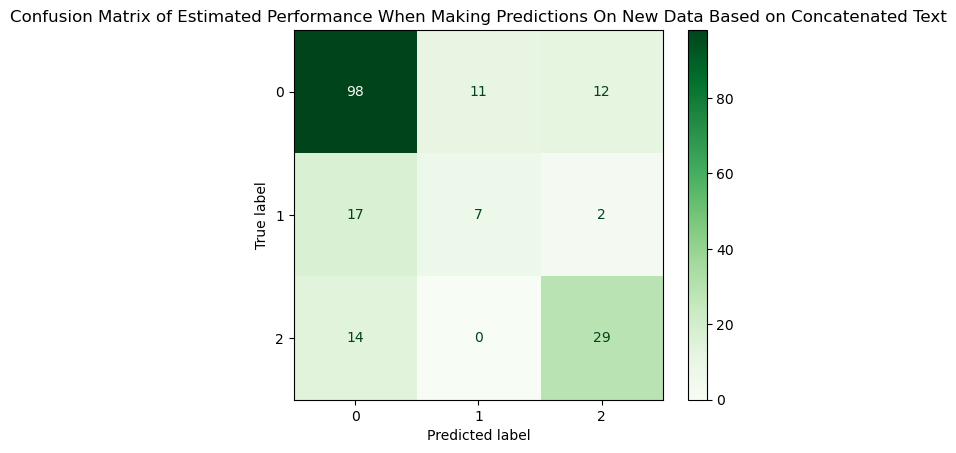

In [16]:
conf_matrix = confusion_matrix(actuals, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=mlp.classes_)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix of Estimated Performance When Making Predictions On New Data Based on Concatenated Text')
plt.show()

Look at if the metrics are better with dimensionality reduction applied to the GloVe embeddings

In [17]:
umap_reducer = umap.UMAP(n_components=2, random_state=42) 
umap_result = umap_reducer.fit_transform(d2vVectors)

c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [18]:
X = umap_result
y = euct_df['manual_label'].values

In [22]:
print("Initial DataFrame shape:", euct_df.shape)
euct_df.dropna(subset=['concat_corpus', 'manual_label'], inplace=True)  # Drop rows with NaN values in relevant columns
print("Shape after dropping NaNs:", euct_df.shape)

Initial DataFrame shape: (190, 12)
Shape after dropping NaNs: (190, 12)


In [23]:
print(f'Features shape: {X.shape}, Target shape: {y.shape}')

Features shape: (190, 2), Target shape: (190,)


In [24]:
if X.shape[0] != y.shape[0]:
    raise ValueError("Features and target variable have inconsistent number of samples.")

In [19]:
parameters = {'mlpclassifier__hidden_layer_sizes': [(5,), (10,), (5,5), (10,10)], 'mlpclassifier__activation': ['relu', 'tanh', 'logistic'], 'mlpclassifier__learning_rate': ['constant', 'adaptive'], 'mlpclassifier__learning_rate_init': [0.001, 0.01], 'mlpclassifier__solver': ['sgd', 'adam', 'lbfgs'], 'mlpclassifier__random_state': [42]}

mlp = MLPClassifier()
pipeline = make_pipeline(StandardScaler(), mlp)
mlp = GridSearchCV(pipeline, parameters, cv=10)
mlp.fit(X, y)

# Display the best parameters found by GridSearchCV
print("Best parameters found: ", mlp.best_params_)

c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (ma

Best parameters found:  {'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': (10, 10), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__learning_rate_init': 0.001, 'mlpclassifier__random_state': 42, 'mlpclassifier__solver': 'lbfgs'}


c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\model_selection\_search.py:412: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_

In [20]:
loo = LeaveOneOut()
predictions = []
actuals = []

In [21]:
mlp = MLPClassifier(activation='tanh', hidden_layer_sizes = (10,10), solver='lbfgs', learning_rate = 'constant', learning_rate_init=0.001, random_state = 42)

In [22]:
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    mlp.fit(X_train, y_train)

    y_pred = mlp.predict(X_test)

    predictions.append(y_pred[0])
    actuals.append(y_test[0])

c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\s

In [23]:
accuracy_weighted = accuracy_score(actuals, predictions)
precision_weighted = precision_score(actuals, predictions, average='weighted')
recall_weighted = recall_score(actuals, predictions, average='weighted')
f1_weighted = f1_score(actuals, predictions, average='weighted')

accuracy_unweighted = accuracy_score(actuals, predictions)
classification_metrics = classification_report(actuals, predictions, output_dict=True)

# Print metrics
print(f'LOOCV Accuracy (Weighted): {accuracy_weighted:.2f}')
print(f'LOOCV Precision (Weighted): {precision_weighted:.2f}')
print(f'LOOCV Recall (Weighted): {recall_weighted:.2f}')
print(f'LOOCV F1 Score (Weighted): {f1_weighted:.2f}')
print()

print(f'LOOCV Accuracy (Unweighted): {accuracy_unweighted:.2f}')
print("Precision, Recall, and F1 Score by Class:")
for cls, metrics in classification_metrics.items():
    if cls.isdigit():  # Filter class-specific metrics
        print(f"  Class {cls}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1 Score={metrics['f1-score']:.2f}")

# Calculate mean and standard deviation of precision, recall, and F1 scores across classes
class_precisions = [metrics['precision'] for cls, metrics in classification_metrics.items() if cls.isdigit()]
class_recalls = [metrics['recall'] for cls, metrics in classification_metrics.items() if cls.isdigit()]
class_f1_scores = [metrics['f1-score'] for cls, metrics in classification_metrics.items() if cls.isdigit()]

print()
print(f'Mean and Standard Deviation of Precision: Mean={np.mean(class_precisions):.2f}, Std={np.std(class_precisions):.2f}')
print(f'Mean and Standard Deviation of Recall: Mean={np.mean(class_recalls):.2f}, Std={np.std(class_recalls):.2f}')
print(f'Mean and Standard Deviation of F1 Score: Mean={np.mean(class_f1_scores):.2f}, Std={np.std(class_f1_scores):.2f}')

LOOCV Accuracy (Weighted): 0.69
LOOCV Precision (Weighted): 0.60
LOOCV Recall (Weighted): 0.69
LOOCV F1 Score (Weighted): 0.62

LOOCV Accuracy (Unweighted): 0.69
Precision, Recall, and F1 Score by Class:
  Class 0: Precision=0.70, Recall=0.96, F1 Score=0.81
  Class 1: Precision=0.00, Recall=0.00, F1 Score=0.00
  Class 2: Precision=0.68, Recall=0.35, F1 Score=0.46

Mean and Standard Deviation of Precision: Mean=0.46, Std=0.33
Mean and Standard Deviation of Recall: Mean=0.44, Std=0.40
Mean and Standard Deviation of F1 Score: Mean=0.42, Std=0.33


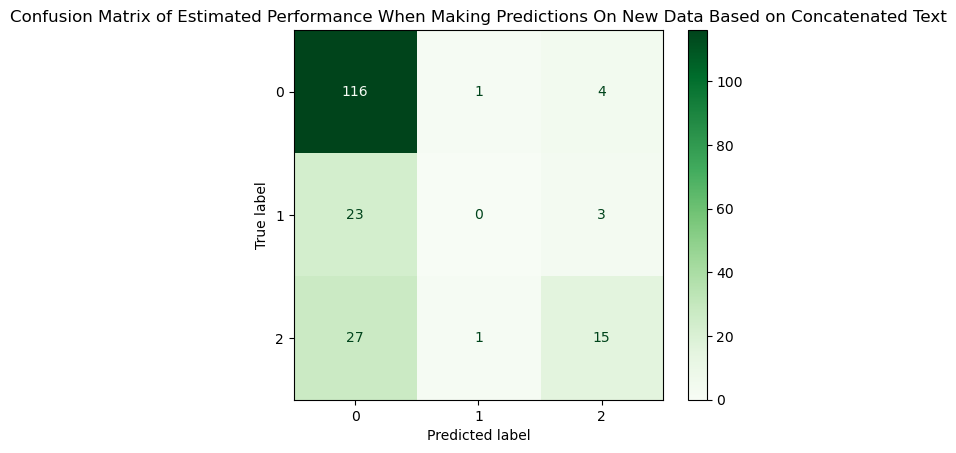

In [24]:
conf_matrix = confusion_matrix(actuals, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=mlp.classes_)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix of Estimated Performance When Making Predictions On New Data Based on Concatenated Text')
plt.show()